In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def forward(angles, armlengths=None):
    if armlengths is None:
        armlengths = np.ones_like(angles)
    else:
        assert len(angles) == len(armlengths)
    coords = [(0, 0)]
    for angle, bone in zip(angles, armlengths):
        offs = coords[-1]
        print(offs)
        coords += [(bone * np.cos(angle) + offs[0],
                               bone *  np.sin(angle) + offs[1])]
    return coords

In [25]:
def plot_keypoints(coords):
    for i, (x, y) in enumerate(coords):
        plt.scatter(x, y)
    plt.legend(range(len(coords)))
    plt.show()

(0, 0)
(1.0, 0.0)


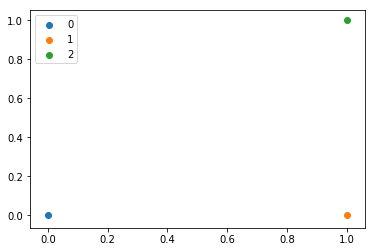

In [31]:
plot_keypoints(forward([0, np.pi/2]))